In [1]:
import math
from functools import cache
import pandas as pd
import time
import numpy as np
from scipy.optimize import linear_sum_assignment

In [2]:
# -----------------------------------------------------------------------------
# Algorithms
# -----------------------------------------------------------------------------

def held_karp(adj_matrix, is_closed=False):
    """
    Solve the traveling salesman problem using Held-Karp algorithm.
    
    Parameters:
    adj_matrix: adjacency matrix where adj_matrix[i][j] is the distance from node i to node j
    is_closed: if true, the path will be hamiltonian circuit, if false the path will start at node 0 and end at node n-1
    
    Returns:
    path: list representing the shortest path from the first node to the last node
    distance: the shortest distance for the path
    """
    
    n = len(adj_matrix)
    if n == 0:
        return [], 0
    
    # Notes on the bit-mask representation (node index starts from 0):
    # S = 1 << (i - 1) <=> node i in S
    # ex. S = 0b101 <=> node 1 and 3 in S
    # ex. S = 0b1000 <=> node 4 in S
    # ex. S = 0b0 <=> node 0 in S

    @cache
    def g(S, k):
        """
        Recursive function to find the minimum distance to reach node k from node 0 after visiting all nodes in set S.
        
        Parameters:
        S: bit-mask representing the set of nodes, where 0, k not in S.
        k: the last node to visit
        
        Returns:
        dist: the minimum distance to reach node k from node 0 through all nodes in S
        prev: the previous node before reaching k
        """
        if S == 0:
            return adj_matrix[0][k], 0
        
        # Evaluate minimum distance by checking all possible previous nodes in the set S
        return min(
            (g(S ^ (1 << (i - 1)), i)[0] + adj_matrix[i][k], i)  # dist(S - {i}, i) + dist(i, k)
            for i in range(1, n) if S & (1 << (i - 1))  # For all i in S
        )

    if is_closed:
        # Initialize S as all nodes except node 0, S = 0b111...1 (n-1 bits)
        S = (1 << (n - 1)) - 1
        # Solve the TSP for the closed path
        dist, last = min(
            (g(S ^ (1 << (i - 1)), i)[0] + adj_matrix[i][0], i)  # dist(S= {i}, i) + dist(i, 0)
            for i in range(1, n)
        )
        # Reconstruct the path by backtracking from the last node
        path = []
        while S:
            path.append(last)
            S ^= 1 << (last - 1)  # S = S - {last}
            _, last = g(S, last)
        path = [0] + path[::-1] + [0]
    else:
        # Initialize S as all nodes except node 0 and node n-1, S = 0b011...1 (n-1 bits with MSB = 0)
        S = (1 << (n - 2)) - 1
        # Solve the TSP for the open path
        dist, last = g(S, n - 1)
        # Reconstruct the path by backtracking from the last node
        path = []
        while S:
            path.append(last)
            S ^= 1 << (last - 1)
            _, last = g(S, last)
        path = [0] + path[::-1] + [n - 1]
       
    # Return the path, distance
    return path, dist

In [3]:
# Points to adj matrix
def points_to_adj_matrix(points):
    n = len(points)
    adj_matrix = [[0] * n for _ in range(n)]
    for i in range(n):
        for j in range(i + 1, n):
            adj_matrix[i][j] = adj_matrix[j][i] = math.dist(points[i], points[j])
    return adj_matrix

In [4]:
def balanced_kmeans(X, k, max_iter=100, tol=1e-4):
    """
    Perform balanced k-means clustering on the given data.

    Parameters:
    - X: array-like of shape (n_samples, n_features)
    - k: number of clusters
    - max_iter: maximum number of iterations
    - tol: tolerance for convergence

    Returns:
    - labels: array of shape (n_samples,) with cluster assignments
    - centroids: array of shape (k, n_features)
    """
    n_samples, n_features = X.shape

    # Determine the cluster sizes
    base_size = n_samples // k
    remainder = n_samples % k
    cluster_sizes = [base_size + 1 if i < remainder else base_size for i in range(k)]

    # Initialize centroids randomly from data points
    rng = np.random.default_rng()
    centroids = X[rng.choice(n_samples, k, replace=False)]
    labels = np.zeros(n_samples, dtype=int)

    for iteration in range(max_iter):
        # Expand centroids to match slots
        centroids_expanded = np.vstack([
            np.tile(centroids[i], (cluster_sizes[i], 1))
            for i in range(k)
        ])

        # Compute cost matrix (squared Euclidean distances)
        cost_matrix = np.linalg.norm(
            X[:, np.newaxis] - centroids_expanded[np.newaxis, :],
            axis=2
        ) ** 2

        # Solve the assignment problem using the Hungarian algorithm
        # cf. https://en.wikipedia.org/wiki/Assignment_problem
        _, col_ind = linear_sum_assignment(cost_matrix)

        # Map assignments to cluster labels
        slot_to_cluster = np.hstack([
            np.full(size, cluster_idx)
            for cluster_idx, size in enumerate(cluster_sizes)
        ])
        new_labels = slot_to_cluster[col_ind]

        # Update centroids
        new_centroids = np.array([
            X[new_labels == c].mean(axis=0) if np.any(new_labels == c)
            else centroids[c]
            for c in range(k)
        ])

        # Check for convergence
        shifts = np.linalg.norm(new_centroids - centroids, axis=1)
        if np.all(shifts < tol):
            centroids = new_centroids
            labels = new_labels
            break

        centroids = new_centroids
        labels = new_labels

    return labels, centroids

In [5]:
# -----------------------------------------------------------------------------
# Data Loading
# -----------------------------------------------------------------------------

# File loading will take some time, so it is better to load the file only once
poi_coords = pd.read_csv('../TSP/poi_coords.csv')

In [6]:
# -----------------------------------------------------------------------------
# Planning Function
# -----------------------------------------------------------------------------

def planning(poi_ids, n_clusters):
    """
    Planning
    
    Parameters:
    poi_ids: list of POI IDs to visit
    n_clusters: number of clusters for balanced K-means
    
    Returns:
    paths: list of paths for each cluster
    """

    poi_idxes = poi_coords['POI_ID'].searchsorted(poi_ids)
    points = poi_coords.iloc[poi_idxes][['X_COORD', 'Y_COORD']].values

    # Perform balanced K-means clustering
    labels, centroids = balanced_kmeans(points, n_clusters)

    # Prepare the adjacency matrix for each cluster
    paths = []
    for c in range(n_clusters):
        mask = (labels == c)
        cluster_points = points[mask]
        cluster_ids = np.array(poi_ids)[mask]

        adj_matrix = points_to_adj_matrix(cluster_points)
        path, _ = held_karp(adj_matrix, is_closed=True)

        paths.append(cluster_ids[path].tolist())
    
    return paths

In [7]:
# -----------------------------------------------------------------------------
# Test
# -----------------------------------------------------------------------------

In [8]:
import matplotlib.pyplot as plt

In [16]:
# Randomly select 5 POIs to visit
poi_indexes = [123, 2341, 345, 234, 1234, 23, 235, 43, 124, 354, 345, 99]
num_cluster = 3
poi_ids = poi_coords['POI_ID'][poi_indexes].tolist()
poi_ids

['POI010000000003QP',
 'POI01000000009OTM',
 'POI01000000000XF8',
 'POI01000000000DGP',
 'POI01000000008RQL',
 'POI010000000000PL',
 'POI01000000000DHQ',
 'POI01000000000196',
 'POI010000000003RQ',
 'POI010000000014QR',
 'POI01000000000XF8',
 'POI010000000002ZX']

In [24]:
points = poi_coords.iloc[poi_indexes][['X_COORD', 'Y_COORD']].values
points


array([[128.33124542,  35.29423901],
       [126.67327289,  37.60431454],
       [128.300165  ,  35.89950348],
       [127.06752088,  37.33000046],
       [127.91024113,  35.90253903],
       [127.00175334,  36.80434445],
       [127.09390981,  37.34277822],
       [126.43785264,  36.82025625],
       [128.33644527,  35.28239915],
       [126.8108545 ,  37.46166741],
       [128.300165  ,  35.89950348],
       [126.61390732,  35.95996343]])

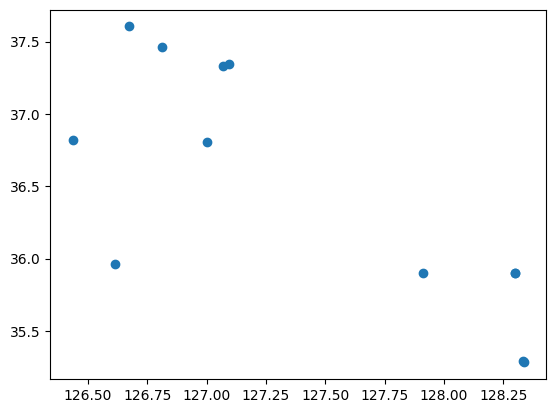

In [25]:
plt.scatter(points[:, 0], points[:, 1])

In [18]:
start = time.time()
paths = planning(poi_ids, num_cluster)
end = time.time()

In [19]:
print(f"Time taken: {end-start:.4f}")

Time taken: 0.0030


In [20]:
print(paths)

[['POI01000000009OTM', 'POI010000000000PL', 'POI010000000002ZX', 'POI01000000000196', 'POI01000000009OTM'], ['POI010000000003QP', 'POI010000000003RQ', 'POI01000000000XF8', 'POI01000000000XF8', 'POI010000000003QP'], ['POI01000000000DGP', 'POI01000000000DHQ', 'POI01000000008RQL', 'POI010000000014QR', 'POI01000000000DGP']]


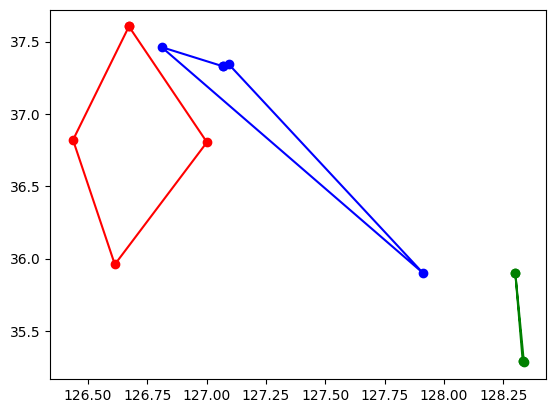

In [28]:
# Visualize the paths
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

for i, path in enumerate(paths):
    indexes = [poi_ids.index(poi_id) for poi_id in path]
    path_points = points[indexes]
    plt.plot(path_points[:, 0], path_points[:, 1], 'o-', color=colors[i])

plt.show()

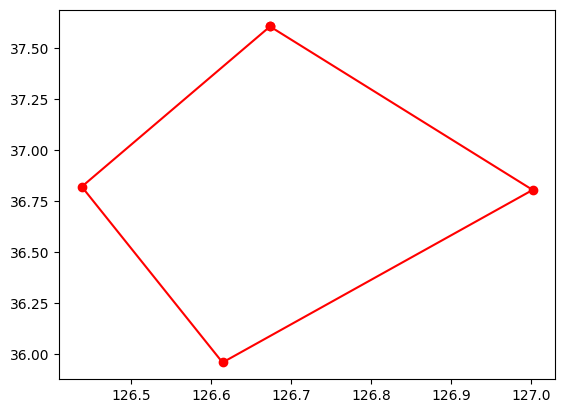

In [31]:
i = 0
path = paths[i]
indexes = [poi_ids.index(poi_id) for poi_id in path]
path_points = points[indexes]
plt.plot(path_points[:, 0], path_points[:, 1], 'o-', color=colors[i])

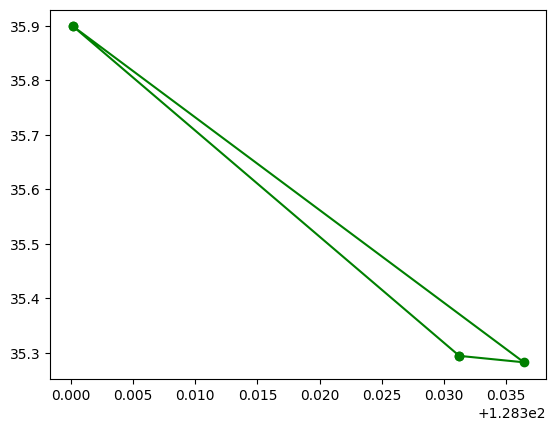

In [32]:
i = 1
path = paths[i]
indexes = [poi_ids.index(poi_id) for poi_id in path]
path_points = points[indexes]
plt.plot(path_points[:, 0], path_points[:, 1], 'o-', color=colors[i])

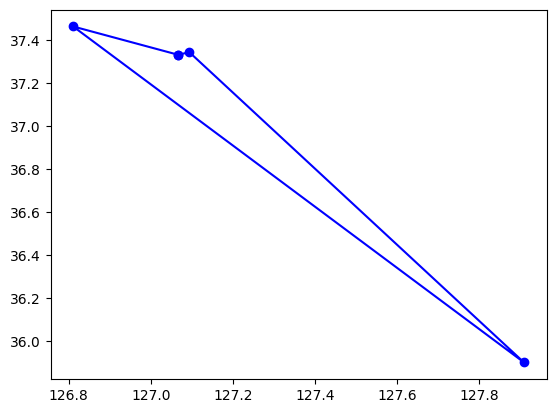

In [33]:
i = 2
path = paths[i]
indexes = [poi_ids.index(poi_id) for poi_id in path]
path_points = points[indexes]
plt.plot(path_points[:, 0], path_points[:, 1], 'o-', color=colors[i])